# Transfer Learning using VGG16 model and the Slim framework

Download the VGG16 weights to the folder "checkpoints" from this source:

https://github.com/tensorflow/models/tree/master/research/slim

The data should be stored as follows

.../train<pre>
/pso
/ecz
</pre>
.../validation <pre>
/pso  
/ecz 
</pre>
.../test<pre>
/pso  
/ecz  
</pre>


The following sources were helpful for implementing the VGG16 model in slim:

https://www.kaggle.com/ardiya/tensorflow-vgg-pretrained
https://github.com/tensorflow/models/blob/master/research/slim/nets/vgg.py

General introduction to TF-slim is given here: https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim
https://github.com/tensorflow/models/blob/master/research/slim/slim_walkthrough.ipynb


In [1]:
# for specifying which GPU to use
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf

/home/nbip/.conda/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
slim = tf.contrib.slim
from tensorflow.contrib.slim.nets import vgg
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import datetime
import glob
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
from random import shuffle

Using TensorFlow backend.


## Set up data paths

In [3]:
checkpoints_dir =          # path to the VGG16 weights
train_data_dir =           # path to the train data directory
validation_data_dir =      # path to the validation data directory
test_data_dir =            # path to the test data directory
tensorboard_dir =          # path to the tensorboard directory

train_pso = glob.glob(train_data_dir + "/pso/*.png")
train_ecz = glob.glob(train_data_dir + "/ecz/*.png")
val_pso = glob.glob(validation_data_dir + "/pso/*.png")
val_ecz = glob.glob(validation_data_dir + "/ecz/*.png")

nb_train_samples = len(train_pso) + len(train_ecz)
nb_validation_samples = len(val_pso) + len(val_ecz)
epochs = 50
DIM = 224
NUM_CLASSES = 2
BATCH_SIZE = 100
img_width, img_height = 224, 224
nchannels = 3
# channel means subtracted in the prerocessing step can be found here 
# https://github.com/tensorflow/models/blob/master/research/slim/preprocessing/vgg_preprocessing.py

In [4]:
datagen = ImageDataGenerator(
    rescale=1. / 255,
    preprocessing_function = preprocess_input
)

train_generator = datagen.flow_from_directory(
        train_data_dir,  
        target_size=(img_height, img_width),  
        batch_size=BATCH_SIZE,
        class_mode='categorical')  

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 40000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [7]:
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

Found 617 images belonging to 2 classes.


## Build the VGG16 model

In [8]:
def build_VGG_model(inputs):
    inputs = tf.cast(inputs, tf.float32)
    #Use Pretrained Base Model
    with tf.variable_scope("vgg_16"):
        with slim.arg_scope(vgg.vgg_arg_scope()):
            net = slim.repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='conv1')
            net = slim.max_pool2d(net, [2, 2], scope='pool1')
            net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
            net = slim.max_pool2d(net, [2, 2], scope='pool2')
            net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3], scope='conv3')
            net = slim.max_pool2d(net, [2, 2], scope='pool3')
            net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv4')
            net = slim.max_pool2d(net, [2, 2], scope='pool4')
            net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv5')
            net = slim.max_pool2d(net, [2, 2], scope='pool5')
    print( "VGG model output shape: ", net.get_shape())
    #Append fully connected layer
    fc = slim.flatten(net)
    print('fc_flatten:\t',fc.get_shape())
    fc = slim.fully_connected(fc, 256, 
            weights_initializer=tf.contrib.layers.xavier_initializer(),
            weights_regularizer=slim.l2_regularizer(1.0), #0.0005
            scope='finetune/fc1')
    fc = slim.dropout(fc, 0.5)
    fc_out = slim.fully_connected(fc, 2,
            activation_fn=tf.nn.softmax,
            weights_initializer=tf.contrib.layers.xavier_initializer(),
            weights_regularizer=slim.l2_regularizer(1.0), #0.0005
            scope='finetune/fc2')
    print('fc_out:\t',fc_out.get_shape())
    return net, fc_out

In [9]:
def loss_and_acc(logits, labels):
    with tf.name_scope("loss"):
        # computing cross entropy per sample
        cross_entropy = -tf.reduce_sum(labels * tf.log(logits+1e-8), reduction_indices=[1])

        # averaging over samples
        cross_entropy = tf.reduce_mean(cross_entropy)
        
        # accuracy
        argmax_logits = tf.to_int32(tf.argmax(logits, axis=1))
        argmax_labels = tf.to_int32(tf.argmax(labels, axis=1))
        correct = tf.to_float(tf.equal(argmax_logits, argmax_labels))
        accuracy = tf.reduce_mean(correct)
        
        # precision
        prec, update_op_prec = tf.metrics.precision(argmax_labels, argmax_logits)
        
        # recall
        rec, update_op_rec = tf.metrics.recall(argmax_labels, argmax_logits)
        
        # AUC of the ROC
        auc, update_op_auc = tf.metrics.auc(labels, logits)

    return cross_entropy, accuracy, argmax_logits, update_op_prec, update_op_rec, update_op_auc
        
def optimize(losses, lr_pl, trainable_vars, g_step):
    
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=lr_pl)

    # applying the gradients
    train_op = optimizer.minimize(losses, var_list=trainable_vars, global_step=g_step)
    
    return train_op

## Define the graph

In [10]:
tf.reset_default_graph()

# input images
x_pl = tf.placeholder(tf.float32, [None, DIM, DIM, nchannels], name="input")
# corresponding labels as onehot encoding
y_pl = tf.placeholder(tf.float32, shape=[None, NUM_CLASSES], name="output")
# learning rate placeholder
lr_pl = tf.placeholder(tf.float32, shape=[], name="learning-rate")
# keep track of training steps. Incremements by 1 each time tf.optimizer.minimize is called
global_step = tf.Variable(initial_value=0, trainable=False)  

# The VGG16 model output and the logits from the fully connected layer on top
vgg16_out, logits = build_VGG_model(x_pl)

# set the trainable vars. We only want to train the fully connected layers
trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"finetune")

# define losses and training operation
loss, accuracy, prediction, precision, recall, auc_op = loss_and_acc(logits, y_pl)
train_op = optimize(loss, lr_pl, trainable_vars, global_step)

# for fine tuning. Here we train both the fully connected layers and the top convolutional layer
trainable_vars2 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"finetune")
trainable_vars2.extend(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"vgg_16/conv5"))
train_op2 = optimize(loss, lr_pl, trainable_vars2, global_step)

trainable_vars3 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"finetune")
trainable_vars3.extend(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"vgg_16/conv5"))
trainable_vars3.extend(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"vgg_16/conv4"))
train_op3 = optimize(loss, lr_pl, trainable_vars2, global_step)

# add TensorBoard summaries for all variables
tf.summary.merge_all()
tf.summary.scalar('Evaluation/loss', loss)
tf.summary.scalar('Evaluation/accuracy', accuracy)


VGG model output shape:  (?, 7, 7, 512)
fc_flatten:	 (?, 25088)
fc_out:	 (?, 2)
y_pl:	 (?, 2)


<tf.Tensor 'Evaluation/accuracy:0' shape=() dtype=string>

## Trainable vars

In [11]:
# check which variables are part of the training
print("\nWe have made the following layers a part of the initial training: ")
[print(var) for var in trainable_vars]
print("\nThe following layers are not a part of the initial training: ")
[print(var) if var not in trainable_vars else ' ' for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) ]
print(" ")


We have made the following layers a part of the training: 
<tf.Variable 'finetune/fc1/weights:0' shape=(25088, 256) dtype=float32_ref>
<tf.Variable 'finetune/fc1/biases:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'finetune/fc2/weights:0' shape=(256, 2) dtype=float32_ref>
<tf.Variable 'finetune/fc2/biases:0' shape=(2,) dtype=float32_ref>

The following layers are not a part of the training: 
<tf.Variable 'vgg_16/conv1/conv1_1/weights:0' shape=(3, 3, 3, 64) dtype=float32_ref>
<tf.Variable 'vgg_16/conv1/conv1_1/biases:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'vgg_16/conv1/conv1_2/weights:0' shape=(3, 3, 64, 64) dtype=float32_ref>
<tf.Variable 'vgg_16/conv1/conv1_2/biases:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'vgg_16/conv2/conv2_1/weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>
<tf.Variable 'vgg_16/conv2/conv2_1/biases:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'vgg_16/conv2/conv2_2/weights:0' shape=(3, 3, 128, 128) dtype=float32_ref>
<tf.Variable 'vgg_16/conv2

## Initialize session

In [12]:
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=1)

# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())  # this is needed for the precision and recall for some reason

# restorethe VGG_16 weights from file
restore = slim.assign_from_checkpoint_fn(
               os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
               slim.get_model_variables("vgg_16"))
restore(sess)

# Tensorboard
file_writer = tf.summary.FileWriter(tensorboard_dir, sess.graph)
# Make run-options
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE,
                            output_partition_graphs=True)
run_metadata = tf.RunMetadata()

INFO:tensorflow:Restoring parameters from /dtu-compute/dabai/Deep_Learning/Notebooks/tmp/checkpoints/vgg_16.ckpt


## Test the forward pass

In [13]:
x_batch, y_batch = train_generator.next()
res = sess.run(fetches=logits, feed_dict={x_pl: x_batch})
assert res.shape == (len(x_batch),2) , "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y_pl.shape) + ' but was ' + str(res.shape)

print('Forward pass successful!')

Forward pass successful!


## Do the training

In [14]:
# setup and write summaries
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summaries_path = "tensorboard/%s" % (timestamp)
summaries = tf.summary.merge_all()

summarywriter_train = tf.summary.FileWriter(summaries_path + '/train', sess.graph)
summarywriter_valid = tf.summary.FileWriter(summaries_path + '/valid', sess.graph)


def train_epoch(learning_rate, training_op):
    num_samples = train_generator.n
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    accs = []
    for i in range(num_batches):
        if i % 10 == 0:
            print(i, end=', ')
        X_batch_tr, y_batch_tr = train_generator.next()
        fetches_tr = [training_op, loss, accuracy, prediction, precision, recall, summaries, global_step, auc_op]
        feed_dict_tr = {x_pl: X_batch_tr, y_pl: y_batch_tr, lr_pl: learning_rate}
        res = sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr)
        costs += [res[1]]
        accs += [res[2]]
        summarywriter_train.add_summary(res[6], res[7])
    auc = res[8]
    prec = res[4]
    rec = res[5]
    # since the prec, rec and auc are running estimates we need to reset it after each epoch
    sess.run(tf.local_variables_initializer())  
    print("")
    return np.mean(costs), np.mean(accs), prec, rec, summaries, auc


def eval_epoch():
    num_samples = validation_generator.n
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    accs = []
    preds = []
    for i in range(num_batches):
        if i % 10 == 0:
            print(i, end=', ')
        X_batch_val, y_batch_val = validation_generator.next()
        fetches_val = [loss, accuracy, prediction, precision, recall, summaries, global_step, auc_op]
        feed_dict_val = {x_pl: X_batch_val, y_pl: y_batch_val}
        res = sess.run(fetches=fetches_val, feed_dict=feed_dict_val)
        costs += [res[0]]
        accs += [res[1]]
        preds += [res[2]]
        summarywriter_valid.add_summary(res[5], res[6])
    preds_ = np.concatenate(preds, axis=0)
    auc = res[7]
    prec = res[3]
    rec = res[4]
    # since the prec and rec is a running estimate we need to reset it after each epoch
    sess.run(tf.local_variables_initializer())  
    print('')
    return np.mean(costs), np.mean(accs), preds_, prec, rec, summaries, auc

In [15]:
NUM_EPOCHS = 60

valid_accs, train_accs, test_accs = [], [], []
valid_precs, train_precs, valid_recs, train_recs = [], [], [], []
train_costs, valid_costs = [], []
train_aucs, valid_aucs = [], []

learning_rate=0.00001
# define which variables are included in the training
tr_op = train_op


print('Number of epochs: %s' % NUM_EPOCHS)

plt.figure(figsize=(20,10))

try:
    for n in range(NUM_EPOCHS):
        print("Epoch %d:" % n, end=', ')
        print('\ntrain:', end=', ')
        train_cost, train_acc, train_prec, train_rec, train_summary, train_auc = train_epoch(learning_rate, tr_op)
        train_costs += [train_cost]
        train_accs += [train_acc]
        train_precs += [train_prec]
        train_recs += [train_rec]
        train_aucs += [train_auc]
        print('valid:', end=', ')
        valid_cost, valid_acc, preds, valid_prec, valid_rec, valid_summary, valid_auc = eval_epoch()
        valid_costs += [valid_cost]
        valid_accs += [valid_acc]
        valid_precs += [valid_prec]
        valid_recs += [valid_rec]
        valid_aucs += [valid_auc]

        # learning rate annealing
        if (n+1) % 20 == 0:
            learning_rate = learning_rate * 0.7
            print("New LR:", learning_rate)
            
        if n == 5:
            tr_op = train_op2
            print("New train_op!")
            
        if n == 15:
            tr_op = train_op3
            print("New train_op!")


        print("train cost {0:.2}, train acc {1:.2}, val cost {2:.2}, val acc {3:.2}".format(
                train_cost, train_acc, valid_cost, valid_acc))
        print("train auc {0:.2}, val auc {1:.2}". format(train_auc, valid_auc))
        print("train prec {0:.2}, train rec {1:.2}, val prec {2:.2}, val rec {3:.2}". format(
                train_prec, train_rec, valid_prec, valid_rec))
        
except KeyboardInterrupt:
    pass

Number of epochs: 60
Epoch 0:, 
train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 
valid:, 0, 10, 20, 30, 
train cost 0.71, train acc 0.55, val cost 0.68, val acc 0.57
train auc 0.56, val auc 0.6
train prec 0.55, train rec 0.55, val prec 0.56, val rec 0.64
Epoch 1:, 
train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 
valid:, 0, 10, 20, 30, 
train cost 0.67, train acc 0.59, val cost 0.67, val acc 0.59
train auc 0.63, val auc 0.62
train prec 0.59, train rec 0.6, val prec 0.6, val rec 0.55
Epoch 2:, 
train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 
valid

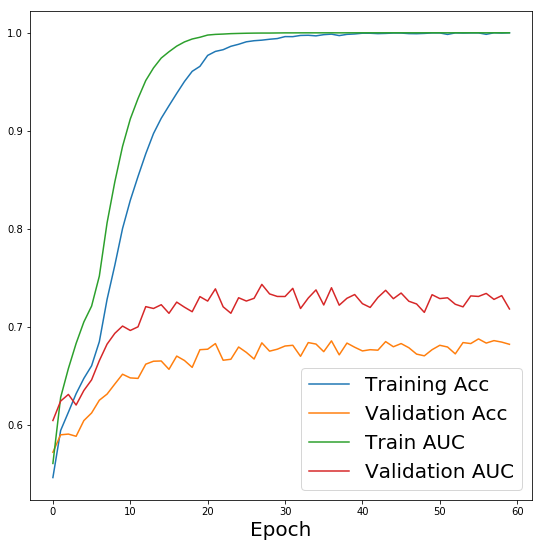

In [148]:
plt.figure(figsize=(9,9))
plt.plot(np.array(train_accs), label='Training Acc')
plt.plot(np.array(valid_accs), label='Validation Acc')
plt.plot(np.array(train_aucs), label='Train AUC')
plt.plot(np.array(valid_aucs), label='Validation AUC')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.savefig('output/TL_ACC_AUC')
plt.show()

## Test data

In [70]:
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

num_samples = test_generator.n
num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))

test_logits = np.zeros((num_samples, 2))
y = np.zeros((num_samples, 2))

for i in range(num_batches):

    x_batch_test, y_batch_test = test_generator.next()
    n_batch = x_batch_test.shape[0]
    print("batch no {}, number of samples: {}".format(i+1, n_batch))
    fetches_test = [vgg16_out, logits, prediction, accuracy, precision, recall, auc_op]
    feed_dict_test= {x_pl: x_batch_test, y_pl: y_batch_test}
    res = sess.run(fetches=fetches_test, feed_dict=feed_dict_test)
    
    test_logits[i*BATCH_SIZE: i*BATCH_SIZE + n_batch, :] = res[1]
    y[i*BATCH_SIZE: i*BATCH_SIZE + n_batch, :] = y_batch_test

Found 617 images belonging to 2 classes.
batch no 1, number of samples: 100
batch no 2, number of samples: 100
batch no 3, number of samples: 100
batch no 4, number of samples: 100
batch no 5, number of samples: 100
batch no 6, number of samples: 100
batch no 7, number of samples: 17


In [142]:
# For the ROC curve
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y[:, 0], test_logits[:, 0])
auc = metrics.auc(fpr, tpr)
print("Sklearn auc: {}".format(auc))

Sklearn auc: 0.7347532588454376


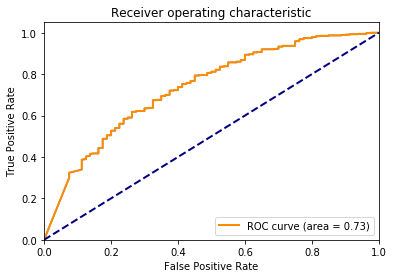

In [147]:
plt.plot(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {0:0.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('output/TL_ROC')
plt.show()

In [138]:
acc = np.sum(np.equal(np.argmax(y, axis=1), np.argmax(test_logits, axis=1)))/num_samples

print("acc: {0:0.2f}, auc: {1:0.2f}".format(acc, auc))

acc: 0.76, auc: 0.73


In [140]:
# indices for positive and negative examples
idxp = np.argmax(y, axis=1) == 0
idxn = np.argmax(y, axis=1) == 1

tp = np.sum(np.equal(np.argmax(y[idxp, :], axis=1), np.argmax(test_logits[idxp, :], axis=1)))
tn = np.sum(np.equal(np.argmax(y[idxn, :], axis=1), np.argmax(test_logits[idxn, :], axis=1)))
fp = np.sum(np.argmax(y[idxn, :], axis=1) != np.argmax(test_logits[idxn, :], axis=1))
fn = np.sum(np.argmax(y[idxp, :], axis=1) != np.argmax(test_logits[idxp, :], axis=1))

print(tp, tn, fp, fn)

prec = tp / (tp + fp)
rec = tp / (tp + fn)
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print("Precision, Recall, TPR, FPR")
print(prec, rec, tpr, fpr)

430 41 39 107
Precision, Recall, TPR, FPR
0.91684434968 0.800744878957 0.800744878957 0.4875


## Inspect classifications on the test set

In [ ]:
n = 17
offset = 0
plt.figure(figsize=(100,100))
for i in range(n):
    plt.subplot(n,1,i+1)
    img = x_batch_test[i + offset]
    mi = np.min(img)
    img = img - mi
    ma = np.max(img)
    img = img / ma
    plt.imshow(img)
    plt.title('logits: {0:3.2}  {1:3.2}, truth: {2}'.format(res[1][i][0],res[1][i][1], y_batch_test[i+offset]))

## Save session

In [ ]:
saver = tf.train.Saver()
saver.save(sess, "output/01TL.ckpt")